# **Telco Customer Churn Prediction**


## Project Content

<a id = 0></a>


### First Step: First Organization

1. [Introduction](#1)
2. [Loading libraries and packages to embark our new journey](#2)
3. [Loading and Checking The Dataset](#3)

### Second Step: Data Preprocessing

4. [Exploratory Data Analysis](#4)
5. [Numeric Fields Analysis](#5)
6. [Categorical Fields Analysis](#6)
7. [Feature Scaling](#7)
8. [Correlation Analysis](#8)
9. [Dealing with Outliers](#9)
10. [Determining Distributions of Numeric Fields](#10)
11. [Appllying One Hot Encoding to Categorical Fields](#11)
12. [Feature Scaling with The RobustScaler Method](#12)
13. [Seperating Data into Two Parts of Train and Test](#13)

### Third and Final Step: Modeling

16. [Modelling (Logistic Regression)](#16)
17. [Cross Validation (Logistic Regression)](#17)
18. [AUC-ROC Curve (Logistic Regression)](#18)
19. [Hyper Parameter Optimization (Logistic Regression)](#19)
20. [Modelling (Decision Tree)](#20)
21. [Cross Validation (Decision Tree)](#21)
22. [AUC-ROC Curve (Decision Tree)](#22)
23. [Hyper Parameter Optimization (Decision Tree)](#23)
24. [Modelling (Support Vector Classifier)](#24)
25. [Cross Validation (Support Vector Classifier)](#25)
26. [AUC-ROC Curve (Support Vector Classifier)](#26)
27. [Hyper Parameter Optimization (Support Vector Classifier)](#27)
28. [Modelling (Random Forest)](#28)
29. [Cross Validation (Support Vector Classifier)](#29)
30. [AUC-ROC Curve (Support Vector Classifier)](#30)
31. [Hyper Parameter Optimization (Support Vector Classifier)](#31)


## 1. Introduction <a id = 1></a>


Text


[Project Content](#0)


## 2. Loading libraries and packages to embark our new journey <a id = 2></a>


In [1]:
# Basic Python Packages

import warnings
warnings.filterwarnings("ignore")

# Numpy Library

import numpy as np

# Pandas Library and Settings

import pandas as pd
pd.set_option("max_columns", None)
pd.options.display.max_colwidth = 100

# SciPy

from scipy.stats import shapiro

# Visualization Libraries (Matplotlib, Seaborn)

import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Sklearn Methods

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
def f_num_unique_values(dataframe, fields = None):
    """
    By this function we can check how many unique values each field has

    Args:
        dataframe (pandas.core.frame.DataFrame): The main dataframe
        fields (list): The fields we want to check number of their unique values
    """
    
    if fields == None:
        fields = dataframe.columns
        
    num_unique_values = []
    
    num_unique_values_df = pd.DataFrame(columns = ["Field_Name", "Unique_Values_Num"], index = range(1, len(fields) + 1))

    for field in fields:
        
        num_unique_values += [dataframe[field].nunique()]
        
    num_unique_values_df["Field_Name"] = fields
    num_unique_values_df["Unique_Values_Num"] = num_unique_values
        
    return num_unique_values_df

In [3]:
def f_unique_values(dataframe, fields = None):
    """
    By this function we can get a dataframe and categorical fields and show a dataframe of unique values of each field.

    Args:
        dataframe (pandas.core.frame.DataFrame): The main dataframe
        fields (list): The fields we want to check their unique values
        
    Returns:
        unique_values_df (pandas.core.frame.DataFrame): A dataframe of fields and their unique values
    """
    
    if fields == None:
        fields = dataframe.columns

    fields_list = []
    unique_values_list = []

    unique_values_df = pd.DataFrame(columns = ["Field_Name", "Unique_Values"], index = range(1, len(fields) + 1))

    for field in fields:

        fields_list += [field]
        field_unique_values_list = list(dataframe[field].unique())
            
        unique_values_str = ""
            
        for values_str in field_unique_values_list:
            if field_unique_values_list.index(values_str) != len(field_unique_values_list) - 1:
                unique_values_str += str(values_str) + " | "
            else:
                unique_values_str += str(values_str)                 
            
        unique_values_list += [unique_values_str]
        
    unique_values_df["Field_Name"] = fields_list
    unique_values_df["Unique_Values"] = unique_values_list
        
    return unique_values_df

In [4]:
def f_not_numeric(dataframe, field):
    """
    This function checks all values of a field from dataframe and shows you the indexes that don't have numerical data type values.
    It also shows a query of the dataframe with those indexes.

    Args:
        dataframe (pandas.core.frame.DataFrame): The main dataframe
        field (string): The field we want to check its data
        
    Returns:
        unique_values_df (pandas.core.frame.DataFrame): A query from main dataframe by indexes that have non numeric values
    """
    
    is_float_list = []
    not_float_index = []

    for value in dataframe[field]:
        
        try:
            value = float(value)
            is_float_list.append(True)
            
        except ValueError:
            is_float_list.append(False)
            
    for i in range(len(is_float_list)):
        
        if is_float_list[i] == False:
            not_float_index.append(i)
    
    non_numeric_dataframe = dataframe.loc[not_float_index, :]
        
    print(f"There are {len(not_float_index)} records with non numeric values.")
    print(f"Indexes of not float datatypes of the field {field} are:")
    print((str(not_float_index))[1 : -1])
    
    return non_numeric_dataframe

In [5]:
def f_cat_to_int(dataframe, fields = None):
    """
    This function helps to change categorical fields' values to numerical format.

    Args:
        dataframe (pandas.core.frame.DataFrame): The main dataframe
        fields (list): The fields which we want to duplicate a integer format of them

    Returns:
        dataframe (pandas.core.frame.DataFrame): A dataframe which categorical fields have integer values
    """
    
    if fields == None:
        fields = list(dataframe.columns)
        
    cat_dict = {}

    for field in fields:
        
        cat_dict[field + "_str"] = list(dataframe[field].unique())
        cat_dict[field + "_int"] = [i for i in range(0, len(list(dataframe[field].unique())))]

        dataframe[field + "_int"] = dataframe[field]
        dataframe[field + "_int"].replace(cat_dict[field + "_str"], cat_dict[field + "_int"], inplace = True)
        
    return dataframe

In [6]:
def f_sorted_correlations(dataframe, fields = None, omited_fields = None, target_field = None, cat_num = None):
    """
    This function get a dataframe and fields to create a dataframe of correlation based on our demands.
    It can show a dataframe of correlations between each two fields in a sorted manner and also it can show a one row sorted correlation values between non-target fields and the target.

    Args:
        dataframe (pandas.core.frame.DataFrame): The main dataframe
        fields (list, optional): The fields we want to check their correlation
        omited_fields (list, optional): The fields we dont want to check their correlation
        target_field (list, optional): The target field we want to check its correlation with other fields
        cat_num (list, optional): Determines if we want to asses correlations between numerical and categorical fields
        
    Returns:
        corr_df (pandas.core.frame.DataFrame): Final correlation matrix
    """
    
    if fields == None:
        fields = list(dataframe.columns)
    
    corr_dict = {}
    all_correlation_df = dataframe[fields].corr()
    
    if cat_num == None:
        
        if omited_fields != None:
            all_correlation_df.drop(omited_fields, axis = 0, inplace = True)
            all_correlation_df.drop(omited_fields, axis = 1, inplace = True)
        
        if target_field == None:
            for row in range(0, len(list(all_correlation_df.columns))):
                for column in range(row, len(list(all_correlation_df.columns))):
                    if row < column:
                        corr_dict[f"{list(all_correlation_df.columns)[row]}, {list(all_correlation_df.columns)[column]}"] = all_correlation_df.iloc[row, column]

            corr_df = pd.DataFrame(columns = ["Fields", "Correlation_Value"])

            corr_df["Fields"] = list(corr_dict.keys())
            corr_df["Correlation_Value"] = list(corr_dict.values())
            corr_df.sort_values(by = "Correlation_Value", inplace = True)
            
        else:
            corr_df = all_correlation_df[[target_field]]
            corr_df = corr_df.sort_values(by = target_field)
            corr_df.drop(target_field, axis = 0, inplace = True)
            corr_df = corr_df.T
            
    else:
        
        corr_df = ((dataframe[cat_num[0] + cat_num[1]].corr()[cat_num[0]]).T)[cat_num[1]]

    return corr_df

In [7]:
def f_vif_function(dataframe, omited_fields = None):
    """
    This function show a dataframe with sorted values of VIF of each field.

    Args:
        dataframe (pandas.core.frame.DataFrame): The main dataframe
        omited_fields (list, optional): The fields we dont want to check their correlation
                
    Returns:
        vif_info (pandas.core.frame.DataFrame): _description_
    """
    
    if omited_fields != None:
        dataframe.drop(omited_fields, axis = 1, inplace = True)
        
    vif_dict = {}
    
    vif_dict["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    vif_df = ((pd.DataFrame(vif_dict, index = dataframe.columns)).sort_values(by = "VIF").T)
    
    return vif_df

In [8]:
def f_train_dev_split(dataframe, target_field):
    """
    This function gets a dataframe and split it into two train and development dataframes.

    Args:
        dataframe (pandas.core.frame.DataFrame): The main dataframe
        target_field (sring): The field we want to create the linear regression model based on that

    Returns:
        x_train, x_develop, y_train, y_develop (pandas.core.frame.DataFrame): Anything we want for modeling
    """
    
    x = dataframe.drop([target_field], axis = 1)
    y = dataframe[target_field]
    
    x_train, x_develop, y_train, y_develop = train_test_split(x, y, test_size = 0.20, random_state = 3)

    print(f"Train (x) dataset shape is:      {x_train.shape}")
    print(f"Train (y) dataset shape is:      {y_train.shape}")

    print(f"Dev (x) dataset shape is:       {x_develop.shape}")
    print(f"Dev (y) dataset shape is:       {y_develop.shape}")
    
    return x_train, x_develop, y_train, y_develop

In [9]:
def f_linear_regression(train , dev):
    """
    This function has been defined to model a linear regression and show R squared value of train and development datasets.

    Args:
        train (list): A list of both x and y dataframes for training the model
        dev (list): A list of both x and y dataframes for checking the model

    Returns:
        results (pandas.core.frame.DataFrame): R squared value of the model of both train and dev datasets
    """
    
    model = LinearRegression()
    model.fit(train[0], train[1])
    
    results = pd.DataFrame(columns = ["Train", "Dev"], index = ["R Squared"])
    results["Train"] = [model.score(train[0], train[1])]
    results["Dev"] = [model.score(dev[0], dev[1])]
    
    fields = list((train[0]).columns)
    coefficients = list(model.coef_)
    coefficients_dict = {fields[i]: coefficients[i] for i in range(len(fields))}
    sorted_coefficients_dict = sorted(coefficients_dict.items(), key = lambda x : x[1])
    
    intercept = model.intercept_
    
    print(f"Coefficients values:")
    
    for i in range(len(fields)):
        print(f"    * {sorted_coefficients_dict[i][0]} : {round((sorted_coefficients_dict[i][1]), 2)}")
    
    print(f"\nInetrcept: {model.intercept_}\n")
    
    return results

[Project Content](#0)


## 3. Loading and Checking The Dataset <a id = 3></a>


### Loading The Dataset


In [10]:
df = pd.read_csv("Telco-Customer-Churn.csv")

### Checking The Dataset


In [11]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Omiting Redundant Fields


In [12]:
df.drop(["customerID"], axis = 1, inplace = True)

### Mending The Datset Fields' Names


In [13]:
fields = [field.capitalize() for field in list(df.columns)]

df.columns = fields

### Examining Missing Values and Datatypes

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            7043 non-null   object 
 1   Seniorcitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Tenure            7043 non-null   int64  
 5   Phoneservice      7043 non-null   object 
 6   Multiplelines     7043 non-null   object 
 7   Internetservice   7043 non-null   object 
 8   Onlinesecurity    7043 non-null   object 
 9   Onlinebackup      7043 non-null   object 
 10  Deviceprotection  7043 non-null   object 
 11  Techsupport       7043 non-null   object 
 12  Streamingtv       7043 non-null   object 
 13  Streamingmovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  Paperlessbilling  7043 non-null   object 
 16  Paymentmethod     7043 non-null   object 


### Examining Unique Values


In [15]:
f_num_unique_values(df)

,Field_Name,Unique_Values_Num
1,Gender,2
2,Seniorcitizen,2
3,Partner,2
4,Dependents,2
5,Tenure,73
6,Phoneservice,2
7,Multiplelines,3
8,Internetservice,3
9,Onlinesecurity,3
10,Onlinebackup,3


### Fixing Datatypes

In [16]:
f_not_numeric(df, "Totalcharges")

There are 11 records with non numeric values.
Indexes of not float datatypes of the field Totalcharges are:
488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754


,Gender,Seniorcitizen,Partner,Dependents,Tenure,Phoneservice,Multiplelines,Internetservice,Onlinesecurity,Onlinebackup,Deviceprotection,Techsupport,Streamingtv,Streamingmovies,Contract,Paperlessbilling,Paymentmethod,Monthlycharges,Totalcharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [17]:
non_numeric_index = [488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]

for i in non_numeric_index:
    df.at[i, "Totalcharges"] = np.nan

df[["Totalcharges"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Totalcharges  7032 non-null   object
dtypes: object(1)
memory usage: 55.1+ KB


In [18]:
imputer = SimpleImputer(strategy = "mean")

df["Totalcharges"] = imputer.fit_transform(df["Totalcharges"].values.reshape(-1, 1))

df.loc[non_numeric_index, ["Totalcharges"]]

,Totalcharges
488,2283.300441
753,2283.300441
936,2283.300441
1082,2283.300441
1340,2283.300441
3331,2283.300441
3826,2283.300441
4380,2283.300441
5218,2283.300441
6670,2283.300441


In [19]:
df[["Totalcharges"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Totalcharges  7043 non-null   float64
dtypes: float64(1)
memory usage: 55.1 KB


### Separating Fields to Numerical and Categorical

In [20]:
num_fields = ["Tenure", "Monthlycharges", "Totalcharges"]

cat_fields = list(df.columns)

for field in num_fields:
    cat_fields.remove(field) 

[Project Content](#0)


## 4. Exploratory Data Analysis <a id = 4></a>


### Examining Statistics of Numeric Fields


In [21]:
print("Numerical fields are:")

(df[num_fields].describe()).T

Numerical fields are:


,count,mean,std,min,25%,50%,75%,max
Tenure,7043.0,32.371149,24.559481,0.00,9.000,29.00,55.00,72.00
Monthlycharges,7043.0,64.761692,30.090047,18.25,35.500,70.35,89.85,118.75
Totalcharges,7043.0,2283.300441,2265.000258,18.80,402.225,1400.55,3786.60,8684.80


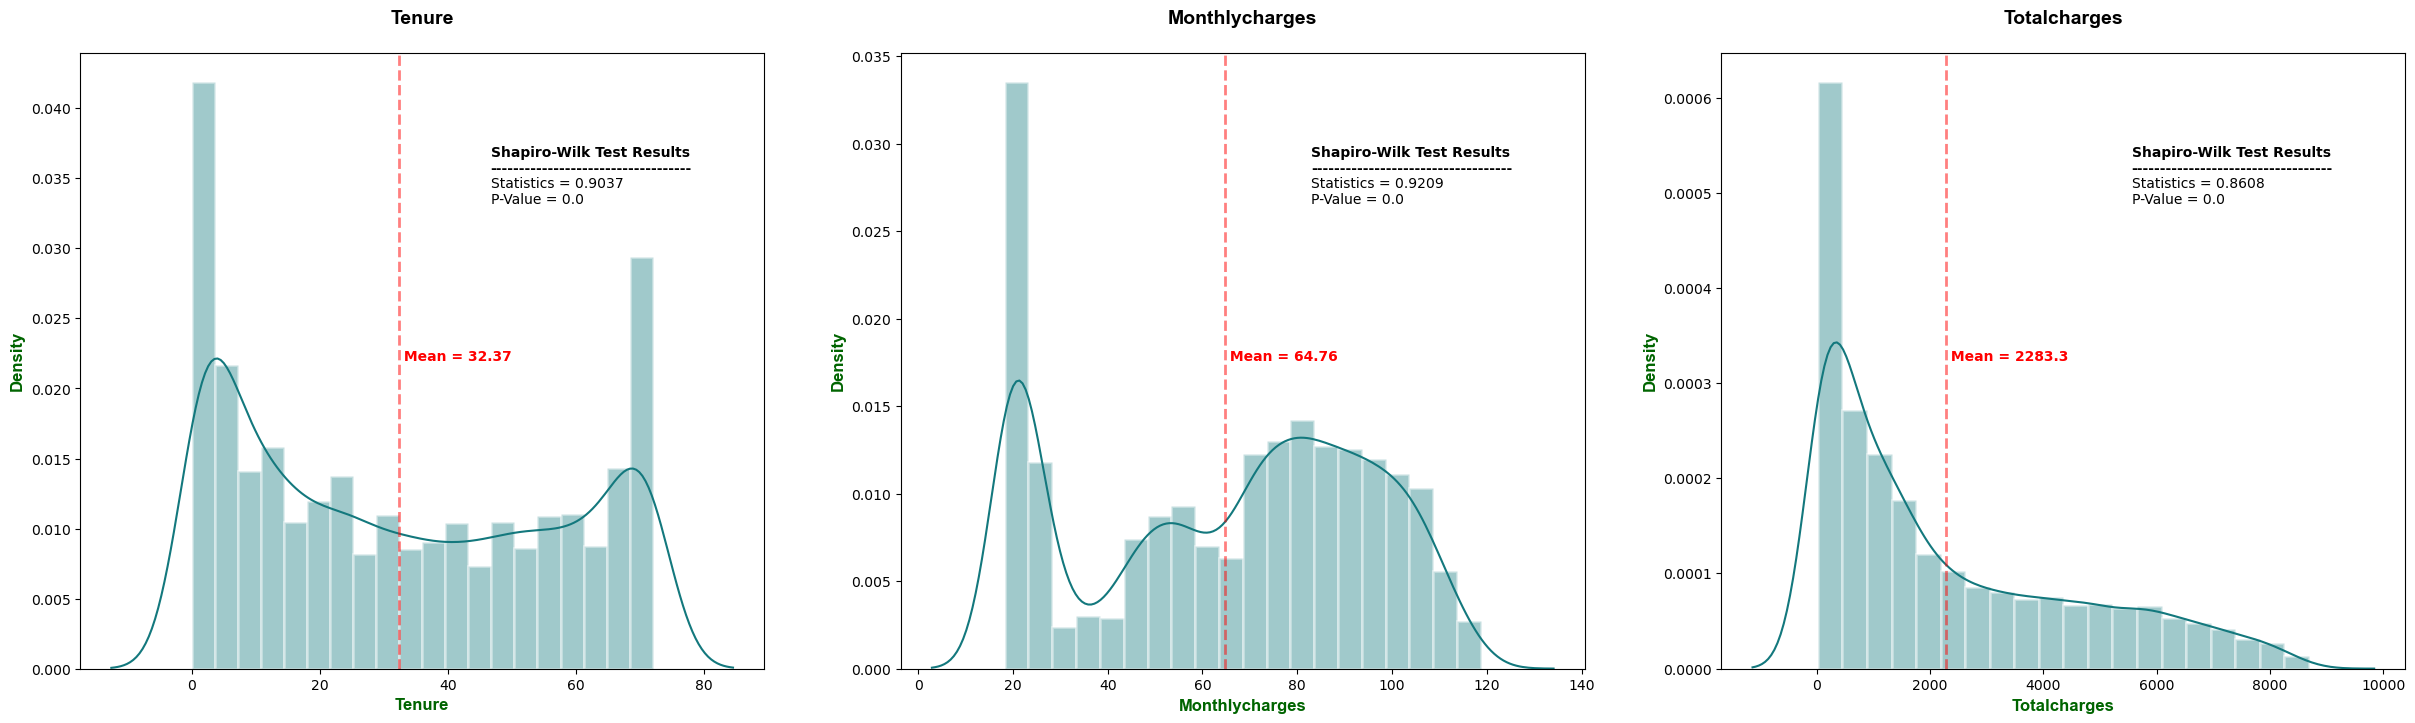

In [22]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}
axes_font = {"family" : "arial", "color" : "darkgreen", "weight" : "bold", "size" : 12}

figure, axes = plt.subplots(1, 3, figsize = (30, 8))

for field in num_fields:
    
    j = num_fields.index(field)
    
    sns.distplot(df[field], kde = True, bins = 20, color = "#13787d", hist_kws = dict(linewidth = 2, edgecolor = "white"), ax = axes[j])
    
    axes[j].axvline(df[field].mean(), color = "r", alpha = 0.5, ls = "--", lw = 2)
    
    axes[j].text(x = df[field].mean(), y = (axes[j].get_ylim()[1]) / 2, s = f" Mean = {round(df[field].mean(), 2)}", color = "red", weight = "bold")
                
    axes[j].set_title(field + "\n", fontdict = title_font)
    axes[j].set_xlabel(field, fontdict = axes_font)
    axes[j].set_ylabel("Density", fontdict = axes_font)
    
    axes[j].annotate("Shapiro-Wilk Test Results\n-----------------------------------",
                        xy = (0.6, 0.8), xycoords = "axes fraction", fontsize = 10, horizontalalignment = "left", verticalalignment = "bottom", weight = "bold")
    axes[j].annotate(f"Statistics = {round(shapiro(df[field])[0], 4)}\nP-Value = {round(shapiro(df[field])[1], 4)}",
                        xy = (0.6, 0.75), xycoords = "axes fraction", fontsize = 10, horizontalalignment = "left", verticalalignment = "bottom")
  
plt.show()

### Examining Statistics of Categorical Fields


In [23]:
print("Categorical fields are:")

f_unique_values(df, fields = cat_fields)

Categorical fields are:


,Field_Name,Unique_Values
1,Gender,Female | Male
2,Seniorcitizen,0 | 1
3,Partner,Yes | No
4,Dependents,No | Yes
5,Phoneservice,No | Yes
6,Multiplelines,No phone service | No | Yes
7,Internetservice,DSL | Fiber optic | No
8,Onlinesecurity,No | Yes | No internet service
9,Onlinebackup,Yes | No | No internet service
10,Deviceprotection,No | Yes | No internet service


In [24]:
colors = ["gold", "mediumturquoise", "navajowhite", "darkorange",
          "lightgreen", "lightseagreen", "lightcoral", "lightslategrey"]

df["Seniorcitizen"].replace([0, 1] , ["No", "Yes"], inplace = True)

fig = make_subplots(rows = 1, cols = 4, specs = [[{"type": "pie"}] * 4],
                    shared_yaxes = True, subplot_titles = cat_fields[:4])
 
for field in cat_fields[:4]:
    
    i = cat_fields.index(field) + 1
    colors_ = colors[2 * i - 2:  2 * i]
    
    data = list(df[field])
    labels = df[field].unique()
    values = [data.count(labels[i]) for i in range(len(labels))]
    
    fig.add_trace(go.Pie(
        labels = labels,
        values = values,
        domain = dict(x = [0, 0.5]),
        name = field,
        marker = dict(colors = colors_, line = dict(color = "white", width = 2)),
        textinfo = "label+percent",
        hovertemplate = "<b>Quantity: </b> %{value} <br>",
        textfont_size = 12,
        showlegend = False), 
        row = 1, col = i)
    
    fig.update_layout(title = dict(text = "Customers Demographic Info", x = 0.01, y = 0.96),
                      title_font_size = 30)

fig.show()

In [25]:
df["Gender"].replace(["Female", "Male"] , [0, 1], inplace = True)
df["Seniorcitizen"].replace(["No", "Yes"] , [0, 1], inplace = True)
df["Partner"].replace(["No", "Yes"] , [0, 1], inplace = True)
df["Dependents"].replace(["No", "Yes"] , [0, 1], inplace = True)

f_unique_values(df, cat_fields[:4])

,Field_Name,Unique_Values
1,Gender,0 | 1
2,Seniorcitizen,0 | 1
3,Partner,1 | 0
4,Dependents,0 | 1


In [26]:
colors = ["#54494B", "#91C7B1", "#679289"]

fig = make_subplots(rows = 1, cols = 2, specs = [[{"type": "pie"}] * 2],
                    shared_yaxes = True, subplot_titles = ["Phoneservice", "Internetservice"])

i = 1
 
for field in ["Phoneservice", "Internetservice"]:
        
    data = list(df[field])
    labels = list(df[field].unique())
    values = [data.count(labels[i]) for i in range(len(labels))]
    
    colors_ = colors.copy()
    
    for label in labels:
        if label == "No":
            colors_[labels.index(label)] = "#EE2E31"
        
    fig.add_trace(go.Pie(
        labels = labels,
        values = values,
        domain = dict(x = [0, 0.5]),
        name = field,
        marker = dict(colors = colors_, line = dict(color = "white", width = 2)),
        textinfo = "label+percent",
        hovertemplate = "<b>Quantity: </b> %{value} <br>",
        textfont_size = 12,
        showlegend = False), 
        row = 1, col = i)
    
    fig.update_layout(title = dict(text = "Signed Up Services", x = 0.01, y = 0.96), title_font_size = 30)
    
    i += 1

fig.show()

In [27]:
fig = px.sunburst(df, path = ["Phoneservice", "Internetservice"])

fig.update_traces(marker = dict(colors = ["#54494B", "#54494B", "#54494B", "#EE2E31", "#EE2E31", "#91C7B1"], line = dict(color = "white", width = 2)),
                  textinfo = "label+percent entry",
                  textfont_size = 12,
                  hovertemplate = "<b>Quantity: </b> %{value} <br>")

fig.update_layout(title = dict(text = "Relationship between Internet and Phone Service", x = 0.01, y = 0.96), title_font_size = 30)

fig.show()

In [28]:
condition_dict = {}

condition_dict[1] = df["Phoneservice"] == "No"
condition_dict[2] = df["Multiplelines"] == "Yes"
condition_dict[3] = df["Phoneservice"] == "Yes"

df.loc[condition_dict[1], "Phoneservice"] = 0
df.loc[condition_dict[2], "Phoneservice"] = 2
df.loc[condition_dict[3], "Phoneservice"] = 1

df.drop(["Multiplelines"], axis = 1, inplace = True)

df.head(5)

,Gender,Seniorcitizen,Partner,Dependents,Tenure,Phoneservice,Internetservice,Onlinesecurity,Onlinebackup,Deviceprotection,Techsupport,Streamingtv,Streamingmovies,Contract,Paperlessbilling,Paymentmethod,Monthlycharges,Totalcharges,Churn
0,0,0,1,0,1,0,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,1,0,0,0,34,1,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,1,0,0,0,2,1,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,1,0,0,0,45,0,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,0,0,0,0,2,1,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [29]:
df["Internetservice"] = df["Internetservice"].replace(["No", "DSL", "Fiber optic"], [0, 1, 2])

df.head(5)

,Gender,Seniorcitizen,Partner,Dependents,Tenure,Phoneservice,Internetservice,Onlinesecurity,Onlinebackup,Deviceprotection,Techsupport,Streamingtv,Streamingmovies,Contract,Paperlessbilling,Paymentmethod,Monthlycharges,Totalcharges,Churn
0,0,0,1,0,1,0,1,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,1,0,0,0,34,1,1,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,1,0,0,0,2,1,1,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,1,0,0,0,45,0,1,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,0,0,0,0,2,1,2,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [30]:
for field in cat_fields[7: 13]:
    df[field] = df[field].replace(["No internet service", "No", "Yes"], [0, 0, 1])
    
f_unique_values(df[cat_fields[7: 13]])

,Field_Name,Unique_Values
1,Onlinesecurity,0 | 1
2,Onlinebackup,1 | 0
3,Deviceprotection,0 | 1
4,Techsupport,0 | 1
5,Streamingtv,0 | 1
6,Streamingmovies,0 | 1


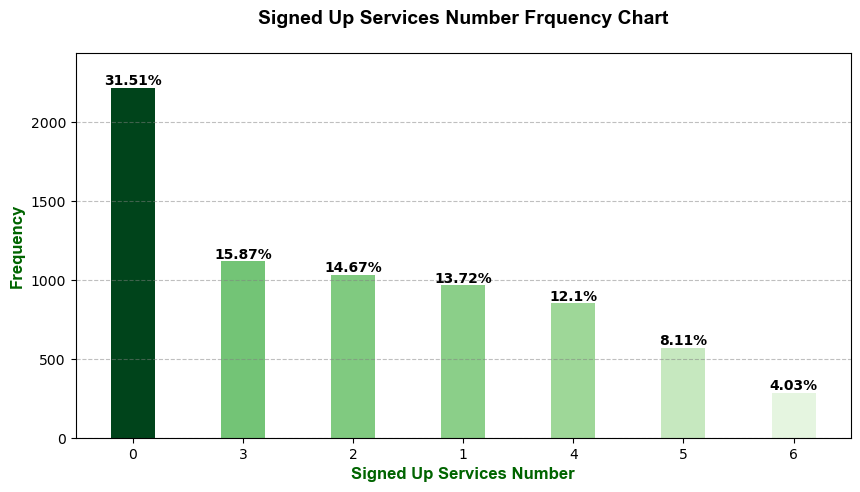

In [31]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}
axes_font = {"family" : "arial", "color" : "darkgreen", "weight" : "bold", "size" : 12}

cmap = plt.cm.get_cmap("Greens")

service_df = df[cat_fields[7: 13]].copy()

service_df["Signed Up Services"] = service_df.sum(axis = 1)

signed_up_services_num = list(service_df["Signed Up Services"].value_counts().index)
signed_up_services_num = [str(i) for i in signed_up_services_num]

frequency = list(service_df["Signed Up Services"].value_counts())
    
fig = plt.figure(figsize = (10, 5))
 
plt.bar(signed_up_services_num, frequency, color = cmap(frequency/np.max(frequency)), width = 0.4)
plt.grid(which = "major", axis = "y", linestyle = "--", color = "grey", alpha = 0.5)

for i, v in enumerate(frequency):
    plt.text(i, v, str(round(((v / len(df)) * 100), 2)) + "%",
             ha = "center", va = "bottom", weight = "bold")
    
plt.ylim([0, 1.1 * max(frequency)])

plt.title("Signed Up Services Number Frquency Chart\n", fontdict = title_font)
plt.xlabel("Signed Up Services Number", fontdict = axes_font)
plt.ylabel("Frequency", fontdict = axes_font)

plt.show()

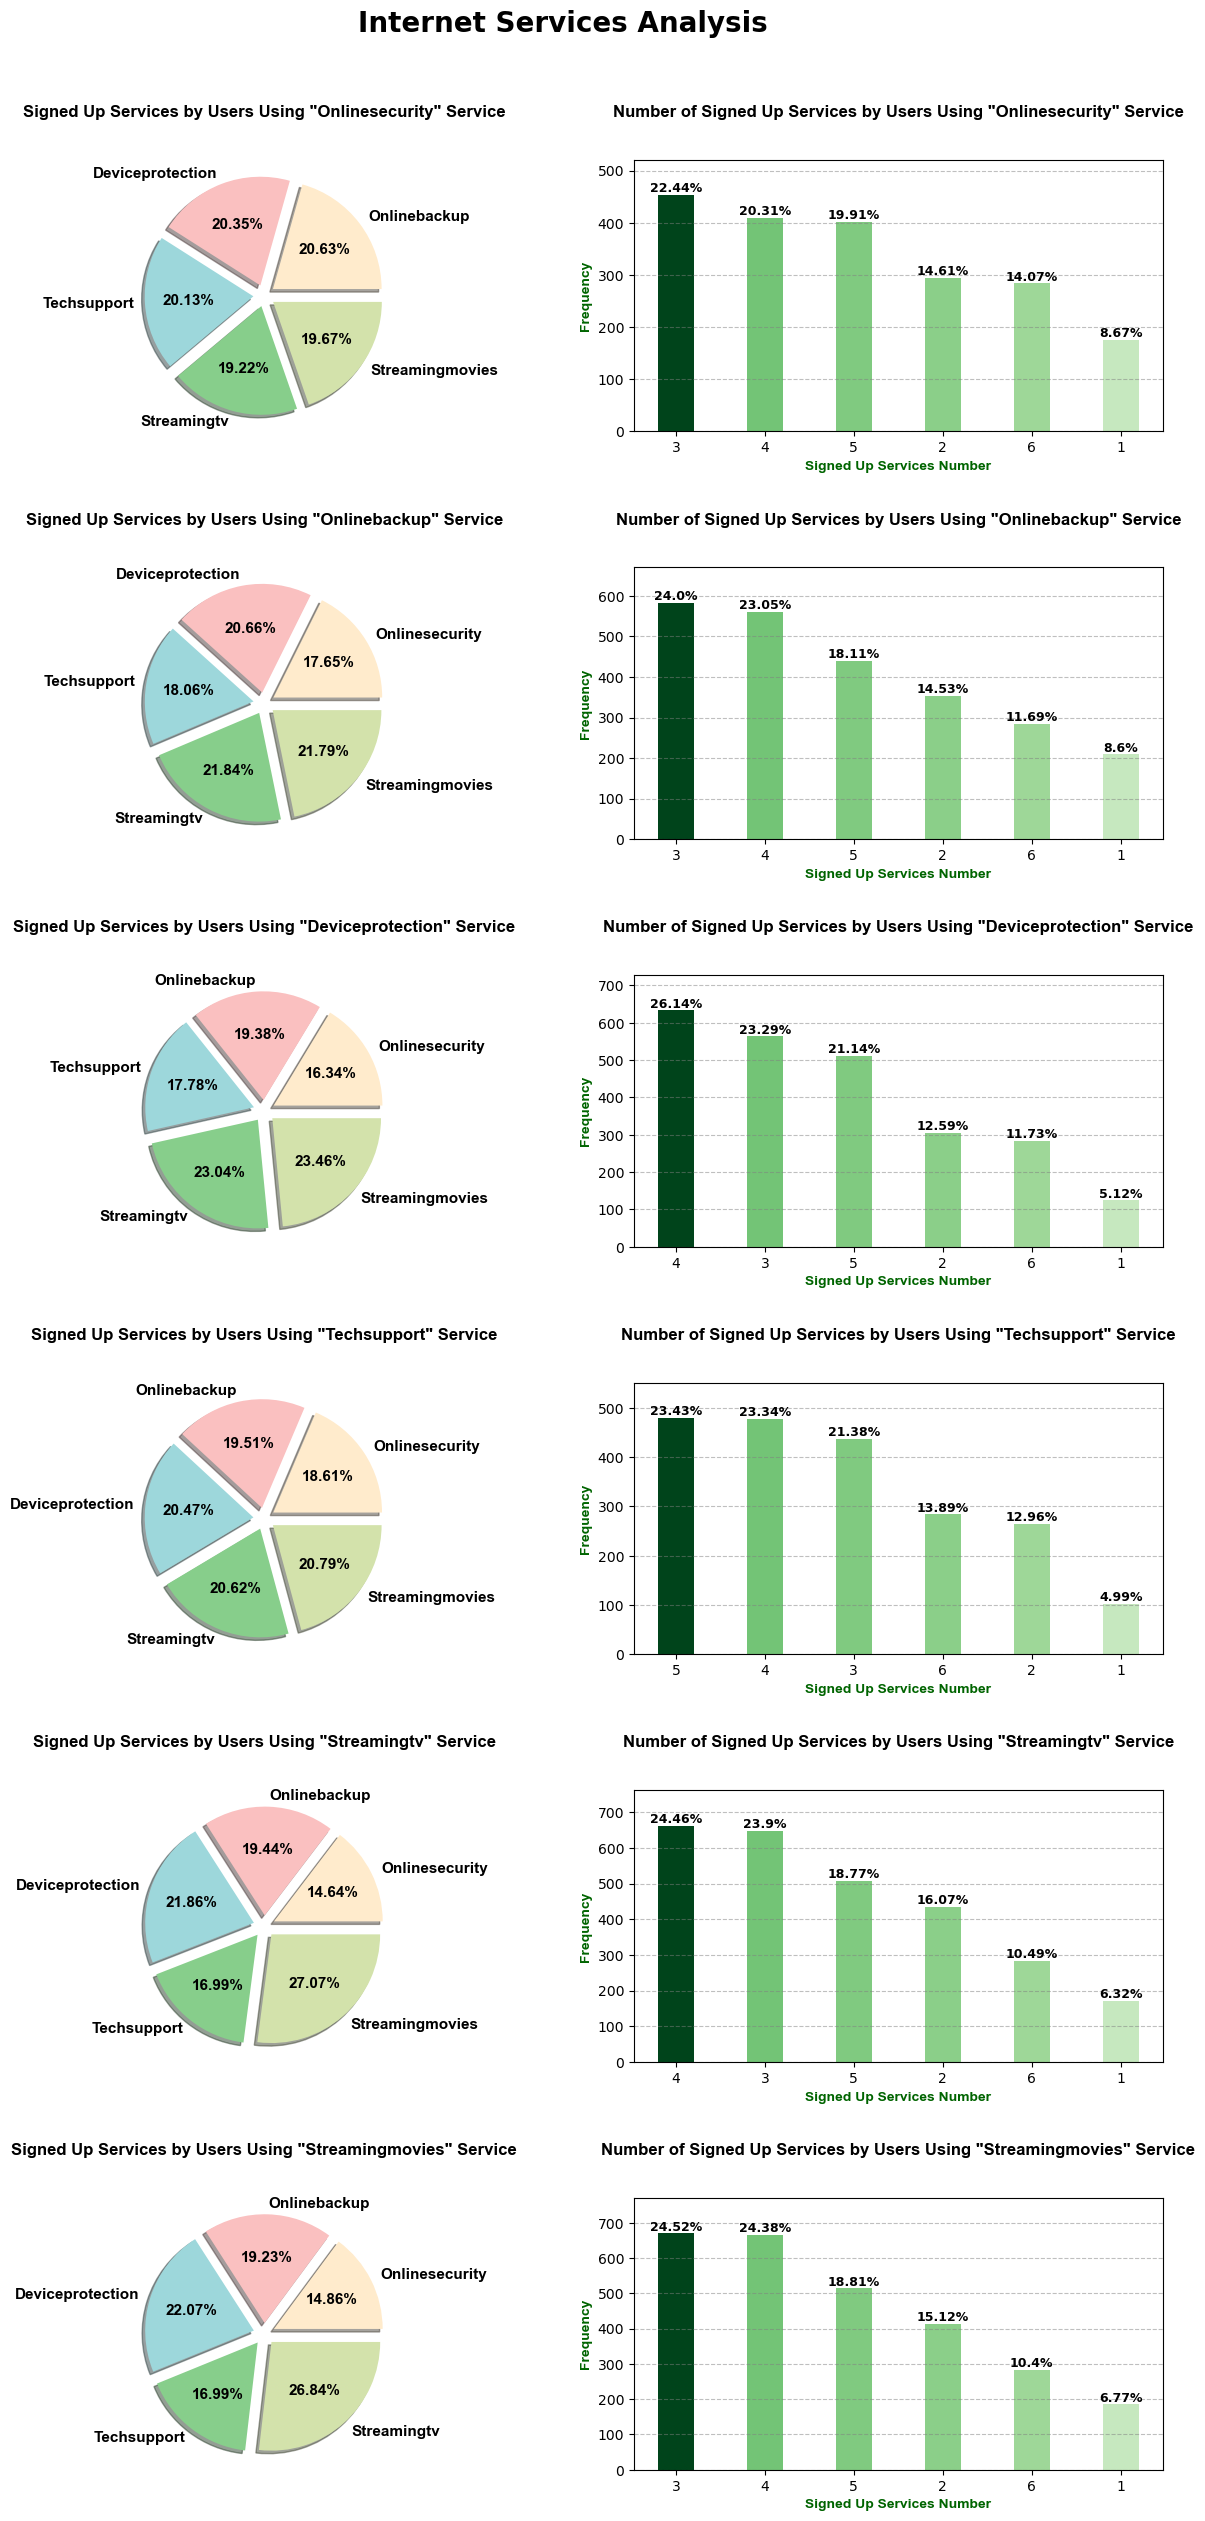

In [32]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 12}
axes_font = {"family" : "arial", "color" : "darkgreen", "weight" : "bold", "size" : 10}
labels_font = {"family" : "arial", "color" : "black", "weight" : "bold", "size" : 11}

colors = ["#FFEBCC", "#FAC0C0", "#9dd7db", "#87CE8B", "#D3E2AB"]

fig, axes = plt.subplots(6, 2, figsize=(15, 30))

for field in cat_fields[7: 13]:
      
    i = cat_fields[7: 13].index(field)
        
    service_query_df = service_df[service_df[field] == 1]
    
    signed_up_services_num = list(service_query_df["Signed Up Services"].value_counts().index)
    signed_up_services_num = [str(i) for i in signed_up_services_num]

    signed_up_services_frequency = list(service_query_df["Signed Up Services"].value_counts())
        
    service_query_df.drop([field, "Signed Up Services"], axis = 1, inplace = True)
    
    other_signedup_services = [field_ for field_ in cat_fields[7: 13] if field_ != field]
    other_signedup_services_frequency = list(service_query_df.sum())

    # Pie Chart Settings
    myexplode = [0.1] * 5
    
    axes[i, 0].pie(other_signedup_services_frequency, labels = other_signedup_services,
                   autopct = "%1.2f%%",textprops = labels_font, explode = myexplode, shadow = True,
                   colors = colors)
    
    axes[i, 0].set_title(f'Signed Up Services by Users Using "{field}" Service\n\n', fontdict = title_font)

    # Bar Chart Settings
    axes[i, 1].bar(signed_up_services_num, signed_up_services_frequency, color = cmap(frequency/np.max(frequency)), width = 0.4)
    axes[i, 1].grid(which = "major", axis = "y", linestyle = "--", color = "grey", alpha = 0.5)
    
    axes[i, 1].set_title(f'Number of Signed Up Services by Users Using "{field}" Service\n\n', fontdict = title_font)
    axes[i, 1].set_xlabel("Signed Up Services Number", fontdict = axes_font)
    axes[i, 1].set_ylabel("Frequency", fontdict = axes_font)

    for j, v in enumerate(signed_up_services_frequency):
        
        axes[i, 1].text(j, v, str(round(((v / len(service_query_df)) * 100), 2)) + "%",
                        ha = "center", va = "bottom", fontsize = 9, weight = "bold")
        axes[i, 1].set_ylim([0, 1.15 * max(signed_up_services_frequency)])
        
fig.subplots_adjust(hspace = 0.5)

fig.suptitle("Internet Services Analysis", y = 0.93, fontsize = 20, fontweight = "bold")

plt.show()

In [45]:
f_cat_to_int(df, ["Churn"])

,Gender,Seniorcitizen,Partner,Dependents,Tenure,Phoneservice,Internetservice,Onlinesecurity,Onlinebackup,Deviceprotection,Techsupport,Streamingtv,Streamingmovies,Contract,Paperlessbilling,Paymentmethod,Monthlycharges,Totalcharges,Churn,Churn_int
0,0,0,1,0,1,0,1,0,1,0,0,0,0,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,1,0,0,0,34,1,1,1,0,1,0,0,0,One year,No,Mailed check,56.95,1889.50,No,0
2,1,0,0,0,2,1,1,1,1,0,0,0,0,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,1,0,0,0,45,0,1,1,0,1,1,0,0,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,0,0,0,0,2,1,2,0,0,0,0,0,0,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,1,0,1,1,1,1,One year,Yes,Mailed check,84.80,1990.50,No,0
7039,0,0,1,1,72,1,2,0,1,1,0,1,1,One year,Yes,Credit card (automatic),103.20,7362.90,No,0
7040,0,0,1,1,11,0,1,1,0,0,0,0,0,Month-to-month,Yes,Electronic check,29.60,346.45,No,0
7041,1,1,1,0,4,1,2,0,0,0,0,0,0,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,1


[Project Content](#0)


## 5. Numeric Fields Analysis <a id = 5></a>


### Correlation Analysis between Numeric Fields and Target


In [47]:
f_sorted_correlations(df, num_fields + ["Churn_int"], target_field = "Churn_int")

,Tenure,Totalcharges,Monthlycharges
Churn_int,-0.352229,-0.199428,0.193356


### Bi-Variate Analysis between Numeric Fields and Target


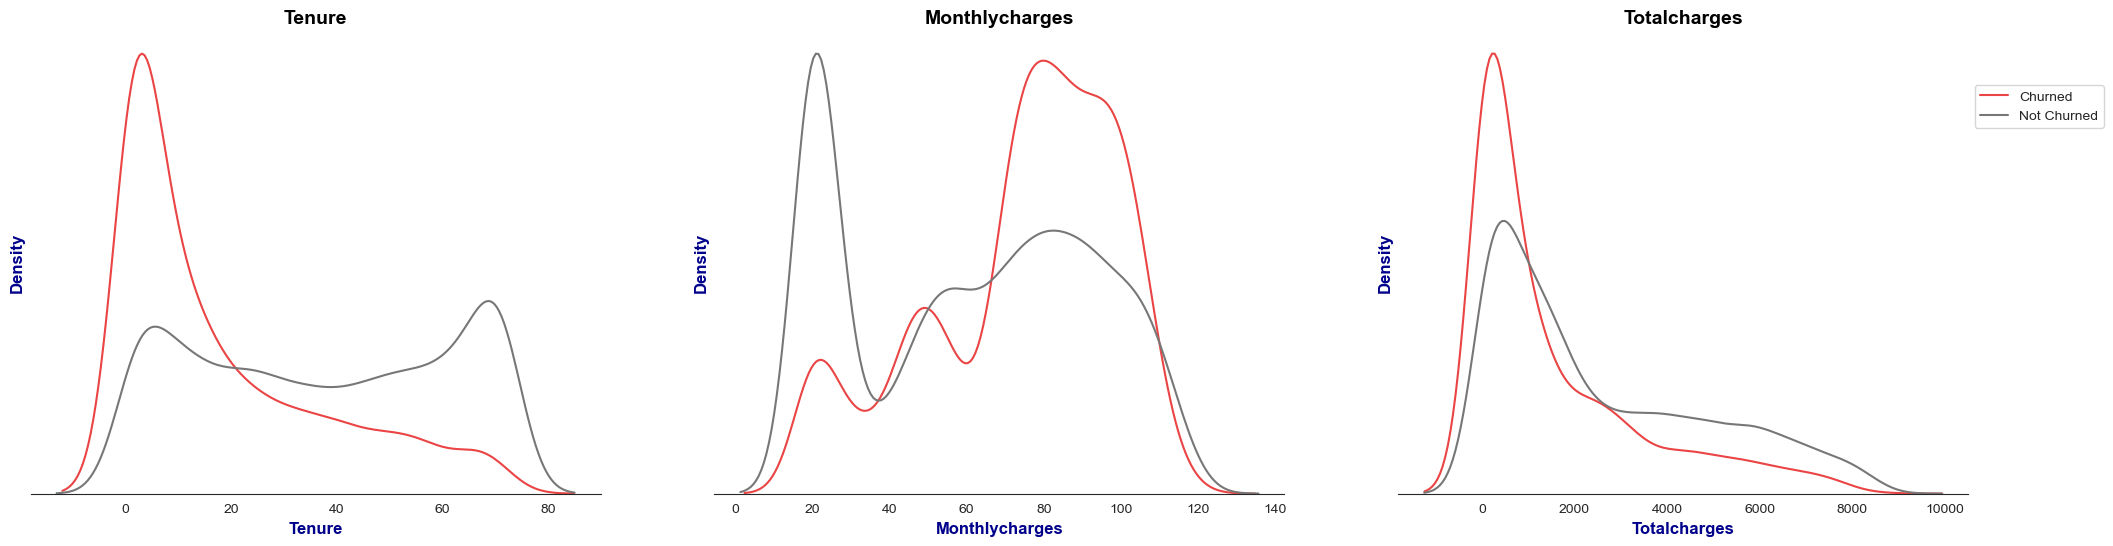

In [169]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}
axes_font = {"family" : "arial", "color" : "darkblue", "weight" : "bold", "size" : 12}

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(25, 6))

for field in num_fields:
    
    i = num_fields.index(field)
    
    sns.distplot(df[df["Churn_int"] == 1][field], ax = axes[i],
                 label = "Churned", hist = False, color = "#EA4444")
    
    sns.distplot(df[df["Churn_int"] == 0][field], ax = axes[i],
                 label = "Not Churned", hist = False, color = "#777777")
    
    sns.despine(left = True, right = True, top = True)
    
    axes[i].set_yticks([])
    
    axes[i].set_title(field, fontdict = title_font)
    axes[i].set_xlabel(field, fontdict = axes_font)
    axes[i].set_ylabel("Density", fontdict = axes_font)

plt.legend(loc = "upper right", bbox_to_anchor=(1.25, 0.9))

plt.show()

### Analysis between Numeric Fields Among Themselves


In [170]:
f_sorted_correlations(df, num_fields)

,Fields,Correlation_Value
0,"Tenure, Monthlycharges",0.247900
2,"Monthlycharges, Totalcharges",0.650468
1,"Tenure, Totalcharges",0.824757


In [177]:
corr_matrix = df[num_fields].corr()

fig = px.imshow(corr_matrix,
                x = corr_matrix.columns,
                y = corr_matrix.columns,
                color_continuous_scale = "RdBu",
                zmin = -1,
                zmax = 1)

fig.update_traces(hovertemplate = "<b>%{x}<br>%{y}</b><br>Correlation: %{z:.2f}<extra></extra>",
                  hoverlabel = dict(bgcolor="white", font = dict(size = 12, color = "black")))

fig.update_layout(title = dict(text = "Correlation between Numeric Fields Among Themselves",
                               x = 0.01, y = 0.96), title_font_size = 30)

fig.show()

[Project Content](#0)


## 6. Categorical Fields Analysis <a id = 6></a>

### Correlation Analysis between Categorical Fields and Target

### Bi-Variate Analysis between Categorical Fields and Target

[Project Content](#0)


## 7. Feature Scaling <a id = 7></a>


[Project Content](#0)


## 9. Dealing with Outliers <a id = 9></a>


[Project Content](#0)


## 13. Appllying One Hot Encoding to Categorical Fields <a id = 13></a>


[Project Content](#0)


## 14. Feature Scaling with The RobustScaler Method <a id = 14></a>


[Project Content](#0)


## 15. Seperating Data into Two Parts of Train and Test <a id = 15></a>


[Project Content](#0)


## 16. Modelling (Logistic Regression) <a id = 16></a>


[Project Content](#0)


## 17. Cross Validation (Logistic Regression) <a id = 17></a>


[Project Content](#0)


## 18. AUC-ROC Curve (Logistic Regression) <a id = 18></a>


[Project Content](#0)


## 19. Hyper Parameter Optimization (Logistic Regression) <a id = 19></a>


[Project Content](#0)


## 20. Modelling (Desicion Tree) <a id = 20></a>


[Project Content](#0)


## 21. Cross Validation (Desicion Tree) <a id = 21></a>


[Project Content](#0)


## 22. AUC-ROC Curve (Desicion Tree) <a id = 22></a>


[Project Content](#0)


## 23. Hyper Parameter Optimization (Desicion Tree) <a id = 23></a>


[Project Content](#0)


## 24. Modelling (Support Vector Classification) <a id = 24></a>


[Project Content](#0)


## 25. Cross Validation (Support Vector Classification) <a id = 25></a>


[Project Content](#0)


## 26. AUC-ROC Curve (Support Vector Classification) <a id = 26></a>


[Project Content](#0)


## 27. Hyper Parameter Optimization (Support Vector Classification) <a id = 27></a>


[Project Content](#0)


## 28. Modelling (Random Forest Classification) <a id = 28></a>


[Project Content](#0)


## 29. Cross Validation (Random Forest Classification) <a id = 29></a>


[Project Content](#0)


## 30. AUC-ROC Curve (Random Forest Classification) <a id = 30></a>


[Project Content](#0)


## 31. Hyper Parameter Optimization (Random Forest Classification) <a id = 31></a>


[Project Content](#0)
